In [600]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pickle
import diagnostic_plots
import datetime


import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn import feature_selection as f_select
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from copy import deepcopy
from fancyimpute import MICE as MICE
from sklearn.cross_validation import KFold
from sklearn.linear_model import Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor    

%matplotlib inline
%config InlineBackend.figure_format = 'svg';

In [601]:
with open('./data/processed/reduced_df2.pkl', 'rb') as picklefile:
    reduced_df2 = pickle.load(picklefile)

In [264]:
y = reduced_df2['price']
X = reduced_df2.drop(('price'), axis = 1, inplace = False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=666)

## Impute the missing data

In [265]:
def standardize_na(df, cols, navalues):
    for col in cols:
        for navalue in navalues:
            df.loc[df[col] == navalue, col] = np.nan
        df[col] = df[col].astype(float)
        #df.loc[df[col] == '123456789.0', col] = np.nan
    return df

In [266]:
col_to_clean = ['city', 'highway', 'engine', 'cylinder', 'horsepower', 'torque']
na_values = ['N/A', '0']

X_train = standardize_na(X_train, col_to_clean, na_values)
X_train_imputed = pd.DataFrame(data = MICE().complete(X_train.as_matrix()), columns=X_train.columns, index=X_train.index);

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


[MICE] Completing matrix with shape (1614, 63)
[MICE] Starting imputation round 1/110, elapsed time 0.002
[MICE] Starting imputation round 2/110, elapsed time 0.016
[MICE] Starting imputation round 3/110, elapsed time 0.025
[MICE] Starting imputation round 4/110, elapsed time 0.033
[MICE] Starting imputation round 5/110, elapsed time 0.040
[MICE] Starting imputation round 6/110, elapsed time 0.046
[MICE] Starting imputation round 7/110, elapsed time 0.053
[MICE] Starting imputation round 8/110, elapsed time 0.059
[MICE] Starting imputation round 9/110, elapsed time 0.066
[MICE] Starting imputation round 10/110, elapsed time 0.072
[MICE] Starting imputation round 11/110, elapsed time 0.078
[MICE] Starting imputation round 12/110, elapsed time 0.085
[MICE] Starting imputation round 13/110, elapsed time 0.091
[MICE] Starting imputation round 14/110, elapsed time 0.098
[MICE] Starting imputation round 15/110, elapsed time 0.104
[MICE] Starting imputation round 16/110, elapsed time 0.111
[M

In [267]:
X_train_imputed[col_to_clean].describe()

,city,highway,engine,cylinder,horsepower,torque
count,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000
mean,23.660341,31.460332,2.719393,4.887620,225.908103,226.990165
std,10.496108,8.609398,1.127051,1.335218,79.851253,91.664611
min,4.285732,12.943178,-1.957391,-0.602032,-126.351307,-125.044940
25%,19.000000,27.000000,2.000000,4.000000,170.250000,171.000000
50%,22.000000,31.000000,2.400000,4.000000,204.000000,207.000000
75%,26.000000,36.000000,3.500000,6.000000,285.000000,265.000000
max,128.000000,109.000000,6.700000,8.000000,550.000000,925.000000


In [269]:
# A temporary workaround: impute all negative values with mean
X_train_imputed[X_train_imputed['engine']<=0]=2.0
X_train_imputed[X_train_imputed['cylinder']<=0]=4.0
X_train_imputed[X_train_imputed['horsepower']<=0]=204.0
X_train_imputed[X_train_imputed['torque']<=0]=207.0

## Basic EDA

In [389]:
df_train = pd.concat((y_train, X_train_imputed), axis=1)
df_train.shape

(1614, 64)

for col in df_train:
    plt.figure()
    ax = plt.scatter(x=df_train[col], y=y_train)
    plt.xlabel(col)
    plt.ylabel('price')

## Model 1: Baseline model with all variables

In [272]:
def get_CV_score(df_x, df_y):
    kf = KFold(n=len(df_x), n_folds=5, shuffle=True, random_state=123)
    model_scores =[]
    for train, test in kf:
        X_train_cv = df_x.iloc[train]
        y_train_cv = df_y.iloc[train]
        X_test_cv = df_x.iloc[test]
        y_test_cv = df_y.iloc[test]
        model = LinearRegression(fit_intercept=False)
        model.fit(X_train_cv, y_train_cv)
        model = sm.OLS(y_train_cv, X_train_cv).fit()
        #score = model.score(X_test_cv, y_test_cv)
        score = mean_squared_error(model.predict(X_test_cv), y_test_cv)
        model_scores.append(score)
    return np.sqrt(np.mean(model_scores))

In [273]:
model1_score = get_CV_score(X_train_imputed, y_train)
print ('Model 1 CV RMSE is:', model1_score)

Model 1 CV RMSE is: 3797.85153572


kf = KFold(n=len(X_train_imputed), n_folds=5, shuffle=True, random_state=123)
model1_scores =[]
for train, test in kf:
    X_train_cv = X_train_imputed.iloc[train]
    y_train_cv = y_train.iloc[train]
    X_test_cv = X_train_imputed.iloc[test]
    y_test_cv = y_train.iloc[test]
    model1 = sm.OLS(y_train_cv, X_train_cv).fit()
    score = mean_squared_error(model1.predict(X_test_cv), y_test_cv)
    model1_scores.append(score)
model1_score = np.sqrt(np.mean(model1_scores))
print ('Model 1 CV RMSE is:', model1_score)

In [274]:
Model_scores = list([['Model 1', model1_score]])

In [275]:
model1_sm = sm.OLS(y_train, X_train_imputed).fit()
score = mean_squared_error(model1_sm.predict(X_train_imputed), y_train)
score = np.sqrt(np.mean(score))
print ('Model 1 training RMSE is:', score)
model1_sm.summary()

Model 1 training RMSE is: 3557.06205015


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     923.3
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        20:24:13   Log-Likelihood:                -15487.
No. Observations:                1614   AIC:                         3.110e+04
Df Residuals:                    1551   BIC:                         3.144e+04
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
images                        50.0525     17.555      2.851      0.004      15.619      84.486
age                        -1077.6710     70.550    -15.275      0.000   -1216.054    -939.288
city                         261.5998     29.652      8.822      0.000     203.437     319.763
highway                     -340.5599     41.984     -8.112      0.000    -422.910    -258.209
transmission                 337.5588    442.199      0.763      0.445    -529.813    1204.931
drive                       3121.7220    292.902     10.658      0.000    2547.197    3696.247
engine                       346.7685    305.685      1.134      0.257    -252.832     946.369
cylinder                     649.9300    232.346      2.797      0.005     194.184    1105.676
horsepower                    13.3679      3.677      3.635      0.000       6.155      20.581
torque                        35.5937      2.608     13.650      0.000      30.479      40.708
rating_5                     -14.3288     12.762     -1.123      0.262     -39.362      10.705
rating_4                      67.4646     33.843      1.993      0.046       1.083     133.847
rating_3                     102.3592     83.844      1.221      0.222     -62.101     266.819
rating_2                    -204.2533    130.340     -1.567      0.117    -459.914      51.407
rating_1                      82.0978    131.879      0.623      0.534    -176.582     340.778
mileage                      -75.7237      5.324    -14.224      0.000     -86.166     -65.281
owner                         94.4620    148.211      0.637      0.524    -196.253     385.177
event                        846.0151    630.851      1.341      0.180    -391.396    2083.426
recall                      -200.2855    242.254     -0.827      0.409    -675.466     274.895
store[T.Fremont, CA]        1794.1665    470.468      3.814      0.000     871.347    2716.986
store[T.Fresno, CA]          903.9281    499.939      1.808      0.071     -76.700    1884.557
store[T.Modesto, CA]        1033.4275    461.834      2.238      0.025     127.543    1939.312
store[T.Pleasanton, CA]      836.9708    442.673      1.891      0.059     -31.330    1705.271
store[T.Reno, NV]            247.9071    463.827      0.534      0.593    -661.887    1157.701
store[T.Roseville, CA]       970.5193    437.173      2.220      0.027     113.008    1828.031
store[T.Sacramento, CA]      973.0282    472.697      2.058      0.040      45.835    1900.222
store[T.San Francisco, CA]   288.9215    454.138      0.636      0.525    -601.868    1179.710
store[T.San Jose, CA]        469.4869    468.934      1.001      0.317    -450.324    1389.298
store[T.Santa Rosa, CA]      202.9982    451.396      0.450      0.653    -682.414    1088.410
Intercept                   1.654e+04   132

** Note the warning: The condition number is large, 1.38e+04. This might indicate that there are strong multicollinearity or other numerical problems. **

In [ ]:
## Check and remove the multi-collinearity

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1])) # in Python3 use list(range(X.shape[1]))
    dropped=True
    while dropped:
        dropped=False
        vif = [variance_inflation_factor(X[variables].values, ix) for ix in range(X[variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[variables]

In [517]:
vl = list([1,2,3])
vl.index(max(vl))

2

In [344]:
variance_inflation_factor(X_train.values,1)

MissingDataError: exog contains inf or nans

In [524]:
df_train = pd.concat((y_train, X_train_imputed), axis=1)
df_train = df_train.iloc[:,1:-1]
df_train.columns[0]

'images'

In [589]:
vif_values = []
for i in range(df_train.shape[1]):
    col = df_train.columns[i]
    vif = variance_inflation_factor(df_train.values, i)
    vif_values.append([col, vif])

In [590]:
vif_table = pd.DataFrame(vif_values, columns=['colname', 'vif'])

In [588]:
df_train.drop(['make[T.Scion]'], axis=1, inplace=True)

In [591]:
vif_table.sort_values('vif', ascending=False)

,colname,vif
0,city,4.640877
3,rating_5,4.166068
7,mileage,4.069810
43,make[T.Porsche],3.974878
38,make[T.Lincoln],3.363082
23,make[T.Cadillac],3.239306
33,make[T.Jaguar],3.220498
4,rating_3,3.031228
27,make[T.Fiat],2.659322
15,"store[T.Roseville, CA]",2.468314


In [592]:
vif_table.colname.tolist()

['city',
 'transmission',
 'drive',
 'rating_5',
 'rating_3',
 'rating_2',
 'rating_1',
 'mileage',
 'event',
 'recall',
 'store[T.Fremont, CA]',
 'store[T.Fresno, CA]',
 'store[T.Modesto, CA]',
 'store[T.Pleasanton, CA]',
 'store[T.Reno, NV]',
 'store[T.Roseville, CA]',
 'store[T.Sacramento, CA]',
 'store[T.San Francisco, CA]',
 'store[T.San Jose, CA]',
 'store[T.Santa Rosa, CA]',
 'make[T.Audi]',
 'make[T.BMW]',
 'make[T.Buick]',
 'make[T.Cadillac]',
 'make[T.Chevrolet]',
 'make[T.Chrysler]',
 'make[T.Dodge]',
 'make[T.Fiat]',
 'make[T.Ford]',
 'make[T.GMC]',
 'make[T.Honda]',
 'make[T.Hyundai]',
 'make[T.Infiniti]',
 'make[T.Jaguar]',
 'make[T.Jeep]',
 'make[T.Kia]',
 'make[T.Land]',
 'make[T.Lexus]',
 'make[T.Lincoln]',
 'make[T.Mazda]',
 'make[T.Mercedes-Benz]',
 'make[T.Mini]',
 'make[T.Nissan]',
 'make[T.Porsche]',
 'make[T.Subaru]',
 'make[T.Toyota]',
 'make[T.Volkswagen]']

In [416]:
X_train_drop_vif = X_train_imputed[cols_with_low_vif]

In [492]:
get_CV_score(df_train, y_train)

9475.9141221579794

In [595]:
model1_sm = sm.OLS(y_train, df_train).fit()
score = mean_squared_error(model1_sm.predict(df_train), y_train)
score = np.sqrt(np.mean(score))
print ('Model 1 training RMSE is:', score)
model1_sm.summary()

Model 1 training RMSE is: 8993.40210618


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     167.5
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        23:23:20   Log-Likelihood:                -16984.
No. Observations:                1614   AIC:                         3.406e+04
Df Residuals:                    1567   BIC:                         3.432e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
city                         367.1659     19.445     18.883      0.000     329.026     405.306
transmission                1070.5720   1093.647      0.979      0.328   -1074.594    3215.738
drive                       1.296e+04    645.598     20.080      0.000    1.17e+04    1.42e+04
rating_5                      16.3218     19.408      0.841      0.400     -21.746      54.389
rating_3                    -480.4857    184.418     -2.605      0.009    -842.217    -118.755
rating_2                    -391.0920    322.903     -1.211      0.226   -1024.460     242.276
rating_1                     112.4289    325.169      0.346      0.730    -525.383     750.241
mileage                       16.4776      9.211      1.789      0.074      -1.590      34.546
event                      -1017.6495   1575.017     -0.646      0.518   -4107.013    2071.714
recall                      -301.6330    605.187     -0.498      0.618   -1488.694     885.428
store[T.Fremont, CA]        1.533e+04   1010.127     15.172      0.000    1.33e+04    1.73e+04
store[T.Fresno, CA]         1.238e+04   1157.270     10.693      0.000    1.01e+04    1.46e+04
store[T.Modesto, CA]        1.186e+04   1060.557     11.178      0.000    9774.806    1.39e+04
store[T.Pleasanton, CA]     1.336e+04   1007.374     13.267      0.000    1.14e+04    1.53e+04
store[T.Reno, NV]           1.331e+04   1043.112     12.761      0.000    1.13e+04    1.54e+04
store[T.Roseville, CA]       1.41e+04    984.858     14.314      0.000    1.22e+04     1.6e+04
store[T.Sacramento, CA]     1.141e+04   1091.977     10.447      0.000    9265.614    1.35e+04
store[T.San Francisco, CA]  1.181e+04   1038.284     11.379      0.000    9778.123    1.39e+04
store[T.San Jose, CA]        1.28e+04   1071.199     11.952      0.000    1.07e+04    1.49e+04
store[T.Santa Rosa, CA]     1.348e+04   1011.447     13.332      0.000    1.15e+04    1.55e+04
make[T.Audi]               -4469.0624   1746.020     -2.560      0.011   -7893.843   -1044.282
make[T.BMW]                  742.2153    956.574      0.776      0.438   -1134.085    2618.515
make[T.Buick]              -8278.4556   1923.469     -4.304      0.000   -1.21e+04   -4505.612
make[T.Cadillac]           -3619.9589   2597.391     -1.394      0.164   -8714.686    1474.768
make[T.Chevrolet]          -5023.1734    974.457     -5.155      0.000   -6934.551   -3111.796
make[T.Chrysler]           -7363.1877   1814.948     -4.057      0.000   -1.09e+04   -3803.206
make[T.Dodge]                 12.9639   1087.405      0.012      0.990   -2119.958    2145.885
make[T.Fiat]               -1.193e+04   2243.884     -5.316      0.000   -1.63e+04   -7527.598
make[T.Ford]               -6168.5149    758.062     -8.137      0.000   -7655.438   -4681.591
make[T.GMC]                  549.5246   197

In [598]:
df_train.tail()

,city,transmission,drive,rating_5,rating_3,rating_2,rating_1,mileage,event,recall,...,make[T.Lexus],make[T.Lincoln],make[T.Mazda],make[T.Mercedes-Benz],make[T.Mini],make[T.Nissan],make[T.Porsche],make[T.Subaru],make[T.Toyota],make[T.Volkswagen]
stock_id,,,,,,,,,,,,,,,,,,,,,
15401792,19.000000,0.0,0.0,59.0,1.0,4.0,2.0,25.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16020059,16.977317,0.0,0.0,17.0,1.0,0.0,1.0,67.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16185842,43.000000,0.0,0.0,1.0,0.0,0.0,0.0,40.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16063121,24.000000,0.0,0.0,38.0,0.0,0.0,1.0,59.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16198309,25.000000,0.0,0.0,8.0,0.0,0.0,0.0,40.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [394]:
df_image_dropped = df_train.drop(['images'], axis=1, inplace=False)

In [395]:
df_image_dropped.shape

(1614, 61)

In [396]:
vif_values2 = []
for i in range(df_image_dropped.shape[1]):
    col = df_image_dropped.columns[i]
    vif = variance_inflation_factor(df_image_dropped.values, i)
    vif_values2.append([col, vif])
vif_values2

[['age', 16.066933949135073],
 ['city', 68.174686202471975],
 ['highway', 222.73501296072109],
 ['transmission', 1.5711469985341822],
 ['drive', 2.2571082991873741],
 ['engine', 99.101569613173339],
 ['cylinder', 169.72678110203537],
 ['horsepower', 95.134915338782051],
 ['torque', 49.528893900984762],
 ['rating_5', 11.388776611412347],
 ['rating_4', 15.042864952273687],
 ['rating_3', 3.9637590605993585],
 ['rating_2', 2.5289139963959011],
 ['rating_1', 2.2084566889458159],
 ['mileage', 8.5712598297909661],
 ['owner', 6.8563495201539668],
 ['event', 1.9220962761989828],
 ['recall', 1.5039770695331749],
 ['store[T.Fremont, CA]', 2.9979087707205334],
 ['store[T.Fresno, CA]', 2.3883498410026736],
 ['store[T.Modesto, CA]', 2.7222598740056911],
 ['store[T.Pleasanton, CA]', 2.9966329578750583],
 ['store[T.Reno, NV]', 2.7696119915643034],
 ['store[T.Roseville, CA]', 3.07002550392582],
 ['store[T.Sacramento, CA]', 2.7050414325529899],
 ['store[T.San Francisco, CA]', 2.8702501999419909],
 ['sto

In [362]:
df_train = df_train._get_numeric_data()
df_train.head()
df_train = df_train.dropna()

features_formula = "+".join(df_train.columns - ["price"])


# get y and X dataframes based on this regression:
y, X = dmatrices('price ~' + features, df_train, return_type='dataframe')

TypeError: cannot perform __sub__ with this index type: <class 'pandas.core.indexes.base.Index'>

In [338]:
(df_train.columns.tolist() - ['price'])

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [327]:
df_train.shape

(1614, 64)

In [310]:
variables = np.arange(X_train.shape[1])
cols = X_train.columns
c = X_train[cols[variables]].values
vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

MissingDataError: exog contains inf or nans

In [316]:
X_train.shape

(1614, 63)

In [315]:
X_train.dropna()

,images,age,city,highway,transmission,drive,engine,cylinder,horsepower,torque,...,make[T.Mitsubishi],make[T.Nissan],make[T.Pontiac],make[T.Porsche],make[T.Scion],make[T.Smart],make[T.Subaru],make[T.Toyota],make[T.Volkswagen],make[T.Volvo]
stock_id,,,,,,,,,,,,,,,,,,,,,
16057160,20,5,24.0,34.0,0,0,1.8,4.0,170.0,184.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16057266,20,4,26.0,34.0,0,0,1.4,4.0,138.0,148.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15867037,21,2,25.0,32.0,0,0,2.0,4.0,189.0,207.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16211748,0,2,17.0,24.0,0,0,3.0,6.0,425.0,406.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16062460,21,4,20.0,29.0,0,0,2.0,4.0,240.0,270.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16062763,20,4,18.0,26.0,0,0,3.5,6.0,280.0,250.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16182316,21,3,26.0,36.0,0,0,1.4,4.0,138.0,148.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16211408,21,2,29.0,38.0,1,0,1.4,4.0,98.0,94.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15823992,21,3,29.0,37.0,0,0,1.8,4.0,132.0,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [306]:
np.isinf(c[:,0]).any()
len(c[:,0])

1614

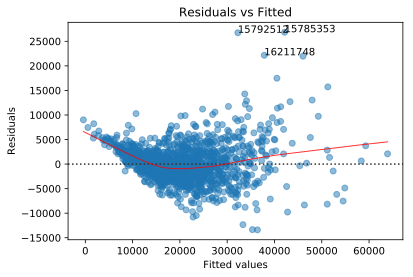

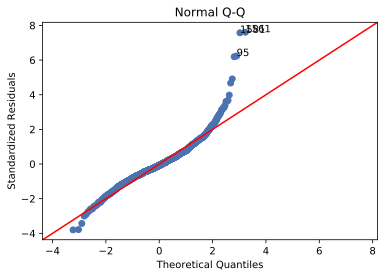

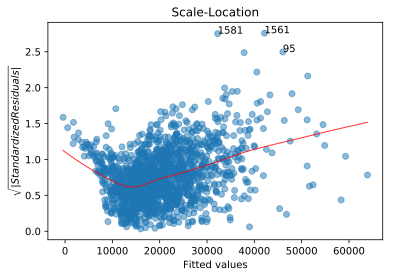

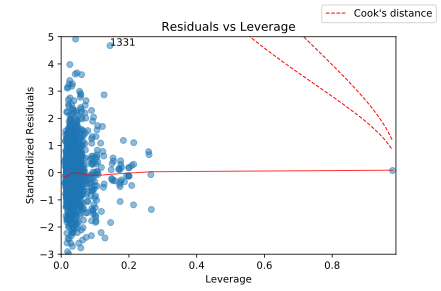

In [190]:
diagnostic_plots.diagnostic_plots(X_train_imputed, y_train, model1_sm)

In [191]:
high_leverage = 239
print ('actual price:', y_train[high_leverage])
print ('predicted price', model1_sm.predict(X_train_imputed)[high_leverage])

actual price: 36998.0
predicted price 37867.5606174


** Remove the high leverage point **

In [154]:
index_to_drop = X_train_imputed.index[high_leverage]
X_train_imputed.drop([index_to_drop], axis=0, inplace=True)
y_train.drop([index_to_drop], axis=0, inplace=True)

## Model 2: Include polynomial and interaction terms

In [495]:
df_pvalue = pd.DataFrame(list(zip(model1_sm.params.index, model1_sm.pvalues)), columns=['variable', 'pvalue'])
significant_var = (df_pvalue[df_pvalue['pvalue']<0.001]
                   .sort_values('pvalue')
                   .variable[0:20]
                   .tolist())
print ('Order the variables by p-value and the top 9 are\n', df_pvalue.sort_values('pvalue').iloc[0:20,:])

Order the variables by p-value and the top 9 are
                       variable        pvalue
2                        drive  5.435331e-80
0                         city  8.134743e-72
10        store[T.Fremont, CA]  1.296031e-48
15      store[T.Roseville, CA]  9.081198e-44
19     store[T.Santa Rosa, CA]  1.727881e-38
13     store[T.Pleasanton, CA]  3.775463e-38
14           store[T.Reno, NV]  1.493412e-35
18       store[T.San Jose, CA]  1.424784e-31
17  store[T.San Francisco, CA]  6.985867e-29
12        store[T.Modesto, CA]  5.774231e-28
11         store[T.Fresno, CA]  8.278516e-26
16     store[T.Sacramento, CA]  9.651523e-25
42              make[T.Nissan]  3.043100e-21
46          make[T.Volkswagen]  1.096650e-17
28                make[T.Ford]  8.152844e-16
44              make[T.Subaru]  8.594612e-16
45              make[T.Toyota]  1.179389e-14
31             make[T.Hyundai]  1.787506e-13
41                make[T.Mini]  7.777456e-11
39               make[T.Mazda]  3.559906e-09


In [497]:
df_pvalue[df_pvalue['pvalue'] < .05] .sort_values('pvalue')

,variable,pvalue
2,drive,5.435331e-80
0,city,8.134743e-72
10,"store[T.Fremont, CA]",1.296031e-48
15,"store[T.Roseville, CA]",9.081198e-44
19,"store[T.Santa Rosa, CA]",1.727881e-38
13,"store[T.Pleasanton, CA]",3.775463e-38
14,"store[T.Reno, NV]",1.493412e-35
18,"store[T.San Jose, CA]",1.424784e-31
17,"store[T.San Francisco, CA]",6.985867e-29
12,"store[T.Modesto, CA]",5.774231e-28


In [ ]:
significant_var = 

In [193]:
X_train_poly = X_train_imputed[significant_var]

In [194]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias = False)
X_train_interact = pd.DataFrame(poly.fit_transform(X_train_poly), columns = poly.get_feature_names(significant_var), index = X_train_poly.index)
tmp = X_train_imputed.drop((significant_var), axis=1)
X_train_int = pd.concat([tmp, X_train_interact], axis=1, join_axes=[tmp.index])

In [200]:
model2_score = get_CV_score(X_train_int, y_train)
print ('Model 2 CV RMSE is:', model2_score)
Model_scores.append(list(['Model 2', model2_score]))

Model 2 CV RMSE is: 4388.31334887


In [202]:
model2_sm = sm.OLS(y_train, X_train_int).fit()
score = mean_squared_error(model2_sm.predict(X_train_int), y_train)
score = np.sqrt(np.mean(score))
print ('Model 2 training RMSE is:', score)
model2_sm.summary()

Model 2 training RMSE is: 3202.87796177


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     115.5
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        17:01:50   Log-Likelihood:                -15318.
No. Observations:                1614   AIC:                         3.081e+04
Df Residuals:                    1525   BIC:                         3.129e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
images                                31.6818     16.189      1.957      0.051      -0.074      63.438
city                                 251.1381     27.471      9.142      0.000     197.253     305.024
highway                             -303.1763     38.508     -7.873      0.000    -378.710    -227.643
transmission                        -110.2572    411.703     -0.268      0.789    -917.821     697.307
engine                               382.8495    300.334      1.275      0.203    -206.263     971.962
cylinder                             951.1682    221.080      4.302      0.000     517.516    1384.821
horsepower                            19.9078      4.325      4.603      0.000      11.425      28.391
rating_5                             -11.9150     11.868     -1.004      0.316     -35.195      11.365
rating_4                              53.3214     31.845      1.674      0.094      -9.143     115.786
rating_3                              54.0223     78.508      0.688      0.491     -99.974     208.018
rating_2                            -182.5060    120.535     -1.514      0.130    -418.937      53.925
rating_1                              60.2658    120.996      0.498      0.618    -177.070     297.601
owner                                 -4.1350    137.725     -0.030      0.976    -274.285     266.015
event                                585.4570    577.028      1.015      0.310    -546.396    1717.310
recall                              -146.0117    223.117     -0.654      0.513    -583.660     291.636
store[T.Fremont, CA]                1517.1435    433.214      3.502      0.000     667.385    2366.902
store[T.Fresno, CA]                  941.2883    467.273      2.014      0.044      24.722    1857.855
store[T.Modesto, CA]                 887.8771    424.706      2.091      0.037      54.807    1720.948
store[T.Pleasanton, CA]              759.4793    408.319      1.860      0.063     -41.446    1560.405
store[T.Reno, NV]                   -148.5506    427.587     -0.347      0.728    -987.272     690.171
store[T.Roseville, CA]               856.3801    404.170      2.119      0.034      63.592    1649.168
store[T.Sacramento, CA]              748.1383    436.165      1.715      0.086    -107.408    1603.685
store[T.San Francisco, CA]           272.6761    416.417      0.655      0.513    -544.134    1089.486
store[T.San Jose, CA]                606.8379    429.967      1.411      0.158    -236.552    1450.228
store[T.Santa Rosa, CA]              410.2884    414.289      0.990      0.322    -402.348    1222.924
make[T.Audi]                        2320.8952    965.314      2.404      0.016     427.411    4214.379
make[T.BMW]                         1818.8419    783.296      2.322      0.020     282.391    33

### Model 3: Data transformation

In [215]:
X_train_trans = deepcopy(X_train_int)
X_train_trans['torque_log'] = np.log(X_train_trans['torque'])
X_train_trans['horsepower_log'] = np.log(X_train_trans['horsepower'])

In [216]:
X_train_trans.shape

(1614, 110)

In [217]:
model3_score = get_CV_score(X_train_trans, y_train)
print ('Model 3 CV RMSE is:', model3_score)
Model_scores.append(list(['Model 3', model3_score]))

Model 3 CV RMSE is: 4322.56984021


### Model 4: Incorporate Lasso regularization

In [498]:
X_train_lasso = deepcopy(df_train)

In [499]:
print(X_train_lasso.shape)
y_train.shape

(1614, 47)


(1614,)

In [500]:
kf = KFold(n=len(X_train_lasso), n_folds=5, shuffle=True)
alphas = [10**x for x in range(-12, 5)]
scores = np.zeros((len(alphas),1))

In [501]:
for j in range(len(alphas)):
    kf_score = []
    for train, test in kf:
        X_train_cv = X_train_lasso.iloc[train]
        y_train_cv = y_train.iloc[train]
        X_test_cv = X_train_lasso.iloc[test]
        y_test_cv = y_train.iloc[test]
        std_scaler = preprocessing.StandardScaler()
        X_train_norm = std_scaler.fit_transform(X_train_cv)
        X_test_norm = std_scaler.transform(X_test_cv)
    
        model =  Lasso(alpha = alphas[j])
        model.fit(X_train_norm, y_train_cv)
        y_test_predict = model.predict(X_test_norm)
        score = mean_squared_error(y_test_predict, y_test_cv)
        kf_score.append(score)
    scores[j] = np.mean(kf_score)
print ('mse for all alpha values \n')
print (pd.DataFrame(list(zip(alphas, scores)), columns=['alpha', 'mse']))

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coo

mse for all alpha values 

           alpha              mse
0   1.000000e-12   [33081063.159]
1   1.000000e-11   [33081063.159]
2   1.000000e-10   [33081063.159]
3   1.000000e-09   [33081063.159]
4   1.000000e-08  [33081063.1589]
5   1.000000e-07  [33081063.1584]
6   1.000000e-06   [33081063.153]
7   1.000000e-05     [33081063.1]
8   1.000000e-04  [33081062.5608]
9   1.000000e-03   [33081057.053]
10  1.000000e-02  [33081002.6025]
11  1.000000e-01  [33080467.8551]
12  1.000000e+00  [33075316.3528]
13  1.000000e+01  [33028868.6413]
14  1.000000e+02  [33393057.6348]
15  1.000000e+03  [47664560.5725]
16  1.000000e+04  [78830128.8607]


In [502]:
best_alpha = alphas[scores.argmin()]
print ('best alpha is:', best_alpha, "\nCV MSE:", np.sqrt(scores.min()))

best alpha is: 10 
CV MSE: 5747.07478995


In [503]:
std_scaler = preprocessing.StandardScaler()
X_train_norm = std_scaler.fit_transform(X_train_lasso)

model4 = Lasso(alpha = best_alpha)
model4.fit(X_train_norm, y_train)
y_train_predict = model4.predict(X_train_norm)
model4_score = mean_squared_error(y_train_predict, y_train)
print ('RMSE of model 4 is:', np.sqrt(model4_score))

RMSE of model 4 is: 5540.53930786


In [505]:
Model_scores.append(['Model 4', np.sqrt(model4_score)])

In [506]:
model4.score

<bound method RegressorMixin.score of Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)>

In [507]:
df_coef = pd.DataFrame(list(zip(X_train_lasso.columns, model4.coef_)), columns = ['variable', 'coefficient'])
print ('Variables we would like to drop are')
print (df_coef[df_coef['coefficient']==0])

Variables we would like to drop are
Empty DataFrame
Columns: [variable, coefficient]
Index: []


In [508]:
cols_to_retain = df_coef[df_coef['coefficient']!=0].variable.tolist()

In [599]:
get_CV_score(X_train_lasso_red, y_train)

9475.9141221579794

In [510]:
X_train_lasso_red = X_train_lasso[cols_to_retain]
model4_sm = sm.OLS(y_train, X_train_lasso_red).fit()
model4_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     167.5
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        21:39:46   Log-Likelihood:                -16984.
No. Observations:                1614   AIC:                         3.406e+04
Df Residuals:                    1567   BIC:                         3.432e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
city                         367.1659     19.445     18.883      0.000     329.026     405.306
transmission                1070.5720   1093.647      0.979      0.328   -1074.594    3215.738
drive                       1.296e+04    645.598     20.080      0.000    1.17e+04    1.42e+04
rating_5                      16.3218     19.408      0.841      0.400     -21.746      54.389
rating_3                    -480.4857    184.418     -2.605      0.009    -842.217    -118.755
rating_2                    -391.0920    322.903     -1.211      0.226   -1024.460     242.276
rating_1                     112.4289    325.169      0.346      0.730    -525.383     750.241
mileage                       16.4776      9.211      1.789      0.074      -1.590      34.546
event                      -1017.6495   1575.017     -0.646      0.518   -4107.013    2071.714
recall                      -301.6330    605.187     -0.498      0.618   -1488.694     885.428
store[T.Fremont, CA]        1.533e+04   1010.127     15.172      0.000    1.33e+04    1.73e+04
store[T.Fresno, CA]         1.238e+04   1157.270     10.693      0.000    1.01e+04    1.46e+04
store[T.Modesto, CA]        1.186e+04   1060.557     11.178      0.000    9774.806    1.39e+04
store[T.Pleasanton, CA]     1.336e+04   1007.374     13.267      0.000    1.14e+04    1.53e+04
store[T.Reno, NV]           1.331e+04   1043.112     12.761      0.000    1.13e+04    1.54e+04
store[T.Roseville, CA]       1.41e+04    984.858     14.314      0.000    1.22e+04     1.6e+04
store[T.Sacramento, CA]     1.141e+04   1091.977     10.447      0.000    9265.614    1.35e+04
store[T.San Francisco, CA]  1.181e+04   1038.284     11.379      0.000    9778.123    1.39e+04
store[T.San Jose, CA]        1.28e+04   1071.199     11.952      0.000    1.07e+04    1.49e+04
store[T.Santa Rosa, CA]     1.348e+04   1011.447     13.332      0.000    1.15e+04    1.55e+04
make[T.Audi]               -4469.0624   1746.020     -2.560      0.011   -7893.843   -1044.282
make[T.BMW]                  742.2153    956.574      0.776      0.438   -1134.085    2618.515
make[T.Buick]              -8278.4556   1923.469     -4.304      0.000   -1.21e+04   -4505.612
make[T.Cadillac]           -3619.9589   2597.391     -1.394      0.164   -8714.686    1474.768
make[T.Chevrolet]          -5023.1734    974.457     -5.155      0.000   -6934.551   -3111.796
make[T.Chrysler]           -7363.1877   1814.948     -4.057      0.000   -1.09e+04   -3803.206
make[T.Dodge]                 12.9639   1087.405      0.012      0.990   -2119.958    2145.885
make[T.Fiat]               -1.193e+04   2243.884     -5.316      0.000   -1.63e+04   -7527.598
make[T.Ford]               -6168.5149    758.062     -8.137      0.000   -7655.438   -4681.591
make[T.GMC]                  549.5246   197

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/statsmodels/stats/outliers_influence.py:323: RuntimeWarning: invalid value encountered in sqrt
  return  self.results.resid / sigma / np.sqrt(1 - hii)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/songlin/Metis/metiswork/project/project2_luther/diagnostic_plots.py:131: RuntimeWarning: invalid value encountered in sqrt
  graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
/Users/

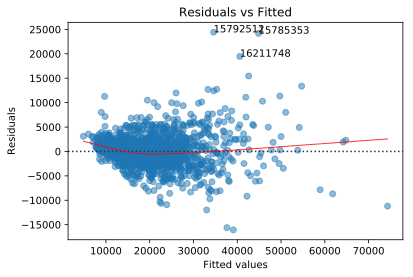

ValueError: figure size must be finite not (nan, nan)

ValueError: figure size must be finite not (nan, nan)

ValueError: figure size must be finite not (nan, nan)

In [241]:
diagnostic_plots.diagnostic_plots(X_train_lasso_red, y_train, model4_sm)

### Model 5: Handpick the variables with significant p-value

In [249]:
X_drop = deepcopy(X_train_trans)
y_drop = deepcopy(y_train)
model_drop = sm.OLS(y_drop, X_drop).fit()

In [250]:
variables_dropped = []
model_score = []
for i in range(0,70):
    least_significant = model_drop.pvalues.argmax()
    # print (least_significant)
    if (model_drop.pvalues.max()>0.05):
        variables_dropped.append(least_significant)
        X_drop.drop((least_significant), axis=1, inplace=True)
        model_drop = sm.OLS(y_drop, X_drop).fit()
        model_score.append(model_drop.rsquared_adj)
pd.DataFrame(list(zip(variables_dropped, model_score)), columns=['dropped_variable','score'] )

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  after removing the cwd from sys.path.


,dropped_variable,score
0,owner,0.865807
1,make[T.Cadillac],0.865892
2,make[T.Honda],0.865979
3,make[T.Porsche] torque,0.866060
4,recall,0.866141
5,mileage make[T.Ford],0.866221
6,"store[T.Reno, NV]",0.866301
7,mileage make[T.Dodge],0.866374
8,drive make[T.Dodge],0.866445
9,make[T.Porsche] mileage,0.866508


In [251]:
model_drop.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     207.5
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        17:35:58   Log-Likelihood:                -15321.
No. Observations:                1614   AIC:                         3.074e+04
Df Residuals:                    1563   BIC:                         3.102e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
images                                38.4378     15.463      2.486      0.013       8.108      68.768
city                                 243.6076     26.169      9.309      0.000     192.277     294.938
highway                             -321.0526     36.857     -8.711      0.000    -393.347    -248.758
engine                               590.0568    273.063      2.161      0.031      54.447    1125.666
cylinder                             649.5312    214.905      3.022      0.003     227.998    1071.065
horsepower                            17.6855      4.122      4.291      0.000       9.601      25.770
rating_4                              37.0507     12.775      2.900      0.004      11.993      62.109
store[T.Fremont, CA]                1036.8491    295.568      3.508      0.000     457.098    1616.601
make[T.Audi]                        2455.9457    667.747      3.678      0.000    1146.171    3765.721
make[T.BMW]                         2076.4513    422.273      4.917      0.000    1248.171    2904.732
make[T.Buick]                      -1912.4163    729.677     -2.621      0.009   -3343.666    -481.167
make[T.Chevrolet]                  -1903.1337    376.210     -5.059      0.000   -2641.064   -1165.204
make[T.Chrysler]                   -5074.4768    677.966     -7.485      0.000   -6404.295   -3744.659
make[T.Fiat]                       -2864.0267    845.348     -3.388      0.001   -4522.161   -1205.892
make[T.GMC]                        -2047.9367    767.532     -2.668      0.008   -3553.437    -542.436
make[T.Hyundai]                    -3160.8588    378.769     -8.345      0.000   -3903.808   -2417.910
make[T.Infiniti]                   -1113.0759    564.158     -1.973      0.049   -2219.663      -6.489
make[T.Jaguar]                      4189.3715   1006.176      4.164      0.000    2215.775    6162.968
make[T.Jeep]                       -2906.3217    455.140     -6.386      0.000   -3799.071   -2013.573
make[T.Kia]                        -3328.0161    526.278     -6.324      0.000   -4360.301   -2295.731
make[T.Land]                        8359.8236    787.661     10.613      0.000    6814.840    9904.808
make[T.Lexus]                       4327.0690    574.419      7.533      0.000    3200.356    5453.782
make[T.Mercedes-Benz]               2088.1012    500.484      4.172      0.000    1106.411    3069.791
make[T.Mercury]                    -3305.0108   1663.892     -1.986      0.047   -6568.706     -41.316
make[T.Nissan]                     -4109.4869    358.903    -11.450      0.000   -4813.469   -3405.505
make[T.Smart]                      -7645.0308   1467.855     -5.208      0.000   -1.05e+04   -4765.858
make[T.Porsche]                     5596.5120   1081.261      5.176      0.000    3475.637    77

In [252]:
model5_score = get_CV_score(X_drop, y_drop)
print ('Model 5 CV RMSE is:', model5_score)
Model_scores.append(list(['Model 5', model5_score]))

Model 5 CV RMSE is: 3599.77365093


In [253]:
Model_scores

[['Model 1', 3812.3027817187781],
 ['Model 2', 4388.3133488714366],
 ['Model 3', 3721.8628006311783],
 ['Model 4', 3181.8765208161112],
 ['Model 5', 3599.7736509307792]]